# 06. Better Way to Gather Good Data

Based on `mock5.py/gen/gen2.cpp` mainly.

This part is to solve TODO1 in \#05

## 학습에 사용될 기보를 개선하기

이전에 학습을 하면서 기보를 다양하게 생성할 수 있지 않을까
생각했고, 그러면 성능이 더 개선되지 않을까 추측했습니다.

여기서는 실제로 몇가지 방식으로 데이터를 많이 뽑아내봅니다.

## $D_8$ Action

오목을 해보면 알지만, 오목의 진행이 같더라도 다른
위치에서 판을 바라보게 되면 판의 모양이 달라 보일 수
있습니다.
예를 들자면 오목 판의 다른 위치에 앉아서
판을 바라보는 경우가 있겠죠.
이렇게 진행은 사실상 동일하지만 바라보는 방향을 바꿀
수 있는 경우는 총 8가지이며, 이러한 action은
4개의 rotaitional symmetries와
4개의 reflection symmetries으로
dihedral group $D_8$을 이루게 됩니다.

만약 agent가 오목을 충분히 학습했다면 위 같은
변환과 무관하게 일정한 수를 두는 것이 정상입니다.
따라서, 하나의 기보가 있을 경우에
위 변환을 통해 생성된 8개의 기보를 모두 학습시키는
것이 맞을 것입니다.

## Interchange Stone Color

위 방향 전환과 마찬가지로 바둑판의 돌의 색을 서로
맞바꾸는 경우에도 승패나 생각하는 방식이
크게 변하지 않아야 정상입니다.
따라서 두 바둑돌 색을 바꾼 기보 역시 만들어냅니다.

## Weighted Record



체스 플레이어는 게임을 완료한 뒤에 복기를 하면서
각 수에 대해 평가를 하고, 다음에는 그런 수를
두지 않도록 학습을 합니다.
이와 비슷하게 인공지능을 만들 때에도 각 기보에
적절한 가중치를 두어서 꼭 학습을 해야되는 수와
그리 중요하지 않은 수를 나누는 것이 좋을 수도 있습니다.

이전에 구현한 DNN은 각 오목판에 대해 얼마나
유리한지를 수치로 계산해내며, 최종적으로 이긴
오목판은 1로, 패배한 오목판은 -1로 근사를 시키는
것이 목표입니다. 그래서 저희는 승패 여부를
바탕으로 1 또는 -1로 라벨링을 하였습니다.
여기서 1, -1 대신에 적당한 실수를 주어서 더
빠르게 1이나 -1로 이동시키거나, 큰 영향을
주지 않도록 할 수 있을 것입니다.
(이 DNN이 결국에는 MCTS를 근사하는 것이기 때문에,
적당한 weight를 주는 것은 기보를 그 횟수만큼
반복해서 추가하는 것과 비슷한 효과일 것이라고
기대할 수 있습니다.)

이 가중치를 주는 방법 중 가장 좋은 것은
실제로 그 상황에서 양측이 모두 최선의 수를 두었을 때
누가 승리하냐를 바탕으로 하는 것일 것입니다.
하지만 이는 불가능하므로, 저희는
저희가 학습시키고 싶은 방향으로 임의로 점수를 주는 것이
좋을 것입니다.

예를 들어서 단순히 판을 분석하는 것으로
열린 3목이나 4목이 얼마나 분포했는지 알 수 있고,
이것이 더 많은 측이 유리하다고 보고 점수를 많이 줄 수
있겠습니다.

이 외에도 오목에서 *빠르게* 이기는 것도 중요하기
때문에, 몇 수만에 이겼느냐를 바탕으로 점수를
일부 줄이는 것도 가능할 것입니다.
예를 들어서 아래와 같은 함수에서
가로축을 종료까지 걸린 수, 세로축이 실제 점수에서
감소시킬 비율이라고 두고
점수를 바꿀 수 있을 것입니다.

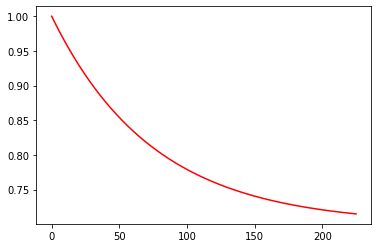

In [7]:
import matplotlib.pyplot as plt
import numpy as np

MAX_STONE = 15 ** 2
SPD_RATIO = 0.3
x = np.linspace(0, MAX_STONE, MAX_STONE + 1)
wy = (1 - SPD_RATIO) + SPD_RATIO * np.exp(-x / MAX * 3)

plt.plot(x, wy, 'r')
plt.show()

그 외에도 현재에는 가중치를 1, -1로만 하였기에 
무승부가 된 판을 다루는 것은 불가능했는데,
양측 가중치를 모두 0으로 줌으로써
무승부 기보에 대해서 학습을 시키는 것도 가능합니다.

## Save as BLOB

학습에 직접 영향을 끼치지는 않지만, 빠르고
컴팩트한 RW를 위해
각 정보를 binary로 저장합니다.

## 구현

구현은
https://github.com/lumiknit/mock5.py
의
`gen2-record`
를 확인해주시면 됩니다.

## 학습의 과정

현재 오목을 학습하는 과정은 다음과 같습니다.

1. 임의의 기보 $R$를 생성
2. 기보 $R$의 각 중간상태에 대해, 해당 플레이어가
최종적으로 이긴다면 $1$, 아니면 $-1$로 라벨링 함.
3. 이 판과 점수를 바탕으로 학습

이 경우에는 하나의 기보에 대해 하나의
(정확히는 돌을 둔 수 만큼의) 학습 데이터가
생기게 됩니다.
하지만 위의 전처리를 포함해보면,

1. 임의의 기보 $R$을 생성
2. $R$에 대해 전처리 $p$를 실행하여 $R'$을 얻음
3. $R'$의 각 중간상태 $X$에 대해
$R', X$를 받아서 $[-1, 1]$ 사이의
적당한 점수를 내놓는 함수 $s$를 적용하여
평가치를 얻음.
4. 이 판 $X$와 $s(R', X)$를 바탕으로 학습

와 같이 정리됩니다.
여기서 $p$는 $D_8$에 따른 대칭이나
돌의 색을 바꾸는
함수이며, $s$는 승, 패, 종료까지 걸린 수 등
최종 결과와 판으로만 알 수 있는 상태에서 점수를
만들어내는 함수가 되겠습니다.
대칭과 돌 색상 반전만 생각하면 $p$의 공간의
기수가 16이므로 1개의 기보에 대해 16개의
학습 데이터가 나오게 됩니다.

지금은 알고리즘으로 기보를 생성한 뒤에 그를
바탕으로 학습을 하지만, 추후에 agent가
충분히 합리적으로 동작하게 되면 기보 생성하는 부분을
agent를 통해 기보를 생성해서 학습하는 것이 가능할
것입니다.